In [72]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Loading the dataset

In [2]:
tsla = yf.Ticker('TSLA')

In [3]:
tsla = yf.Ticker('TSLA')

# get historical data as hist
hist = tsla.history(period="3y")

# Save dataframe as CSV file
hist.to_csv('TSLA.csv')

In [4]:
stock_data = pd.read_csv('TSLA.csv')
stock_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-09-30,16.200001,16.265333,15.740667,16.058001,88197000,0,0.0
1,2019-10-01,16.100000,16.396667,15.942000,16.312668,92439000,0,0.0
2,2019-10-02,16.219334,16.309999,15.962000,16.208668,84471000,0,0.0
3,2019-10-03,15.457333,15.632000,14.952000,15.535333,226267500,0,0.0
4,2019-10-04,15.440667,15.652000,15.204667,15.428667,119925000,0,0.0


In [5]:
# As we are performing UniVariate Time Series Analysis so we will conside only close price.

stock_data = stock_data[['Date','Close']] # filtering the dataframe to date and close price

In [6]:
stock_data.head()

,Date,Close
0,2019-09-30,16.058001
1,2019-10-01,16.312668
2,2019-10-02,16.208668
3,2019-10-03,15.535333
4,2019-10-04,15.428667


In [7]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    756 non-null    object 
 1   Close   756 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.9+ KB


In [9]:
stock_data.Date = pd.to_datetime(stock_data.Date) # convert Date data type ('object') to datetime

In [10]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    756 non-null    datetime64[ns]
 1   Close   756 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.9 KB


In [11]:
stock_data = stock_data.set_index("Date") # setting date as index

In [12]:
stock_data.head() 

,Close
Date,
2019-09-30,16.058001
2019-10-01,16.312668
2019-10-02,16.208668
2019-10-03,15.535333
2019-10-04,15.428667


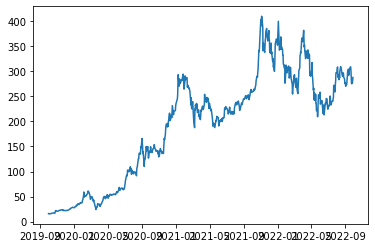

In [13]:
import matplotlib.pyplot as plt
plt.plot(stock_data['Close'])

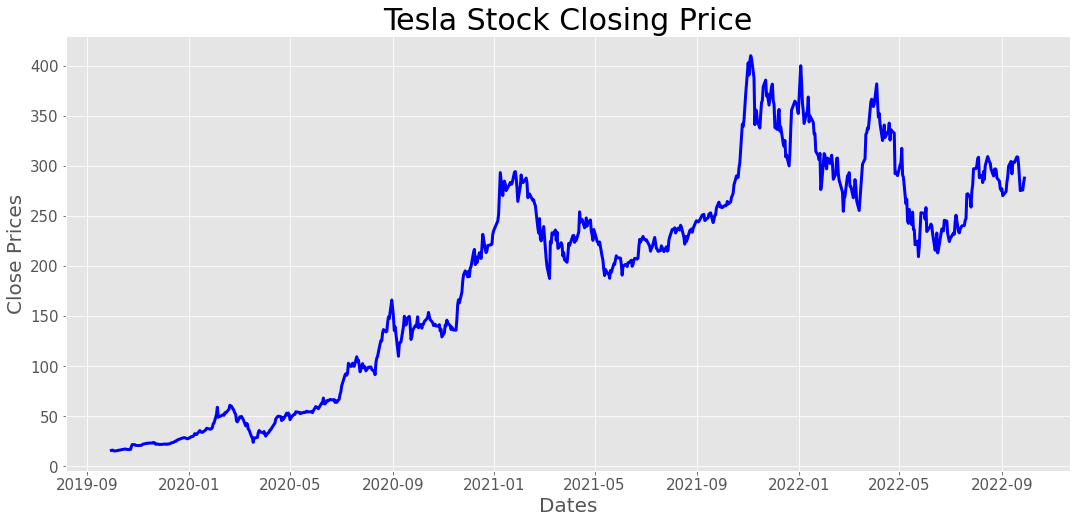

In [14]:
# plotting close price
plt.style.use('ggplot')
plt.figure(figsize=(18,8)) 
plt.grid(True) 
plt.xlabel('Dates', fontsize = 20) 
plt.xticks(fontsize = 15)
plt.ylabel('Close Prices', fontsize = 20)
plt.yticks(fontsize = 15) 
plt.plot(stock_data['Close'], linewidth = 3, color = 'blue')
plt.title('Tesla Stock Closing Price', fontsize = 30)
plt.show()

<AxesSubplot:xlabel='Close', ylabel='Density'>

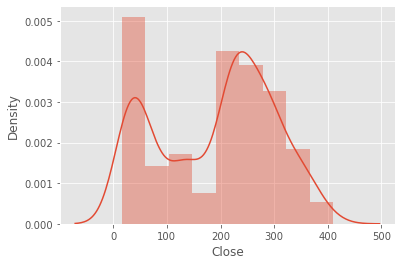

In [15]:
import seaborn as sns
sns.distplot(stock_data['Close'])

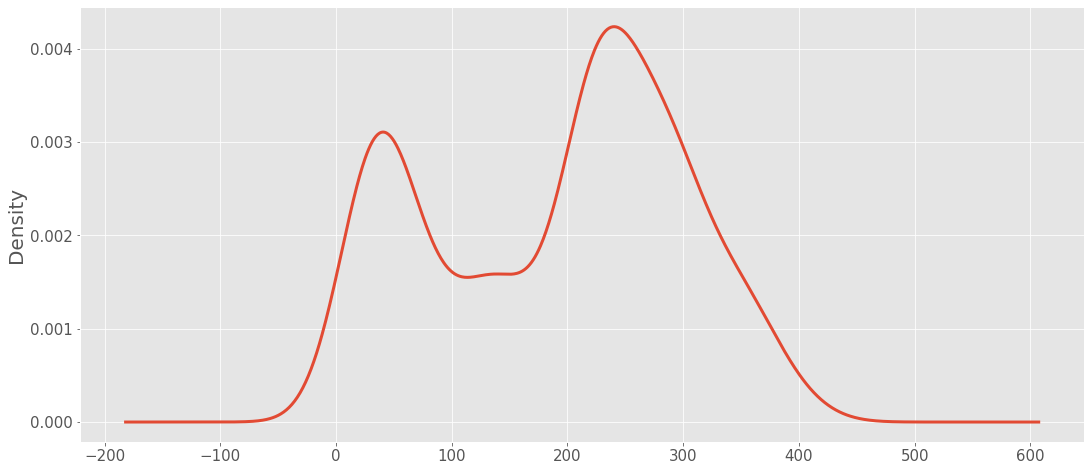

In [16]:
# Distribution of the close price  
df_close = stock_data['Close'] 
df_close.plot(kind='kde',figsize = (18,8), linewidth= 3) 
plt.xticks(fontsize = 15)
plt.grid("both")
plt.ylabel('Density', fontsize = 20)
plt.yticks(fontsize = 15)
plt.show()

In [17]:
stock_data

,Close
Date,
2019-09-30,16.058001
2019-10-01,16.312668
2019-10-02,16.208668
2019-10-03,15.535333
2019-10-04,15.428667
...,...
2022-09-22,288.589996
2022-09-23,275.329987
2022-09-26,276.010010


In [18]:
type(stock_data['Close'])

pandas.core.series.Series

In [19]:
np.mean(stock_data['Close'].head(12))

16.238500038782757

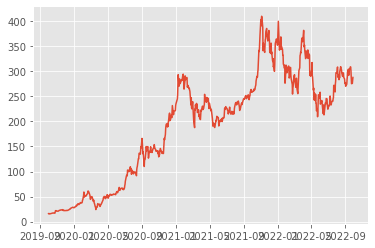

In [20]:
plt.plot(stock_data['Close'])

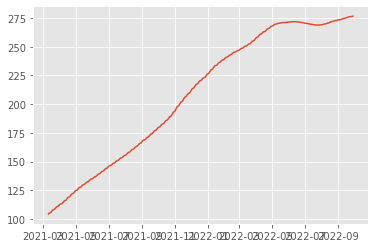

In [21]:
plt.plot(stock_data['Close'].rolling(365).mean())

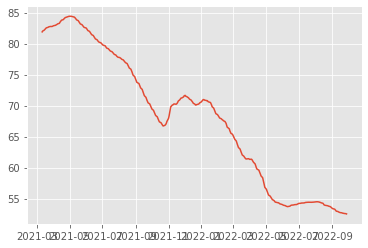

In [22]:
plt.plot(stock_data['Close'].rolling(365).std() )

In [23]:
adfuller(stock_data['Close'],autolag='AIC')

(-1.528866785869556,
 0.5191861102887811,
 10,
 745,
 {'1%': -3.4391580196774494,
  '5%': -2.8654273226340554,
  '10%': -2.5688400274762397},
 5270.450195999186)

In [24]:
#Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() # rolling mean
    rolstd = timeseries.rolling(12).std() # rolling standard deviation
    # Plot rolling statistics:
    plt.figure(figsize = (18,8))
    plt.grid('both')
    plt.plot(timeseries, color='blue',label='Original', linewidth = 3)
    plt.plot(rolmean, color='red', label='Rolling Mean',linewidth = 3)
    plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth = 4)
    plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    

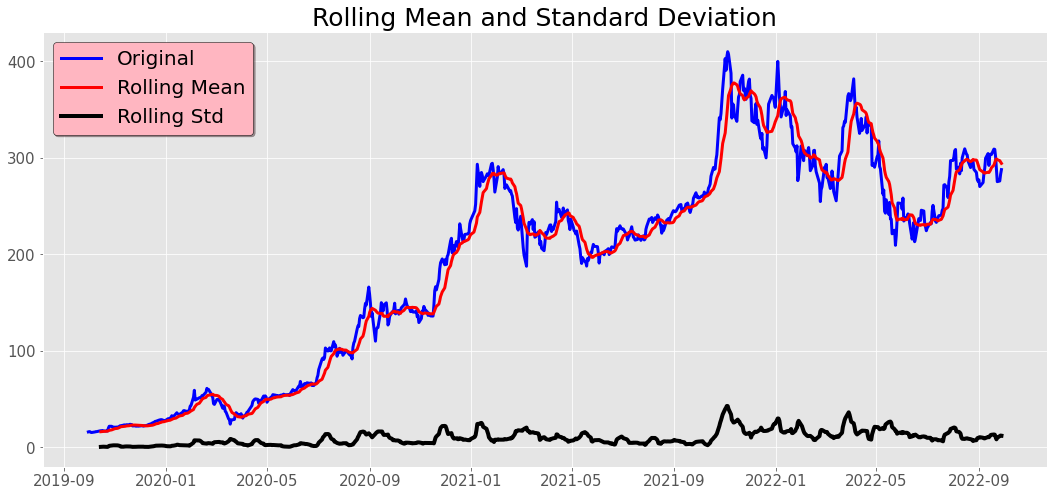

Results of dickey fuller test
Test Statistics                 -1.528867
p-value                          0.519186
No. of lags used                10.000000
Number of observations used    745.000000
critical value (1%)             -3.439158
critical value (5%)             -2.865427
critical value (10%)            -2.568840
dtype: float64


In [25]:
test_stationarity(stock_data['Close'])

We can't reject the Null hypothesis because the p-value is bigger than 0.05. Furthermore, the test statistics exceed the critical values. As a result, the data is not stationary.

Differencing is a method of transforming a non-stationary time series into a stationary one. This is an important step in preparing data to be used in an ARIMA model.
So, to make the data stationary, we need to take the first-order difference of the data. Which is just another way of saying, subtract today’s close price from yesterday’s close price.


In [26]:
df_close=stock_data['Close']

In [27]:
df_close

Date
2019-09-30     16.058001
2019-10-01     16.312668
2019-10-02     16.208668
2019-10-03     15.535333
2019-10-04     15.428667
                 ...    
2022-09-22    288.589996
2022-09-23    275.329987
2022-09-26    276.010010
2022-09-27    282.940002
2022-09-28    287.809998
Name: Close, Length: 756, dtype: float64

In [28]:
df_close.diff()

Date
2019-09-30          NaN
2019-10-01     0.254667
2019-10-02    -0.104000
2019-10-03    -0.673335
2019-10-04    -0.106666
                ...    
2022-09-22   -12.209991
2022-09-23   -13.260010
2022-09-26     0.680023
2022-09-27     6.929993
2022-09-28     4.869995
Name: Close, Length: 756, dtype: float64

In [29]:
# Get the difference of each Adj Close point
tsla_close_diff_1 = df_close.diff()

In [30]:
tsla_close_diff_1

Date
2019-09-30          NaN
2019-10-01     0.254667
2019-10-02    -0.104000
2019-10-03    -0.673335
2019-10-04    -0.106666
                ...    
2022-09-22   -12.209991
2022-09-23   -13.260010
2022-09-26     0.680023
2022-09-27     6.929993
2022-09-28     4.869995
Name: Close, Length: 756, dtype: float64

do differencing until it converts into stationary data where mean and variance are constant


In [31]:
tsla_close_diff_1.dropna(inplace=True)

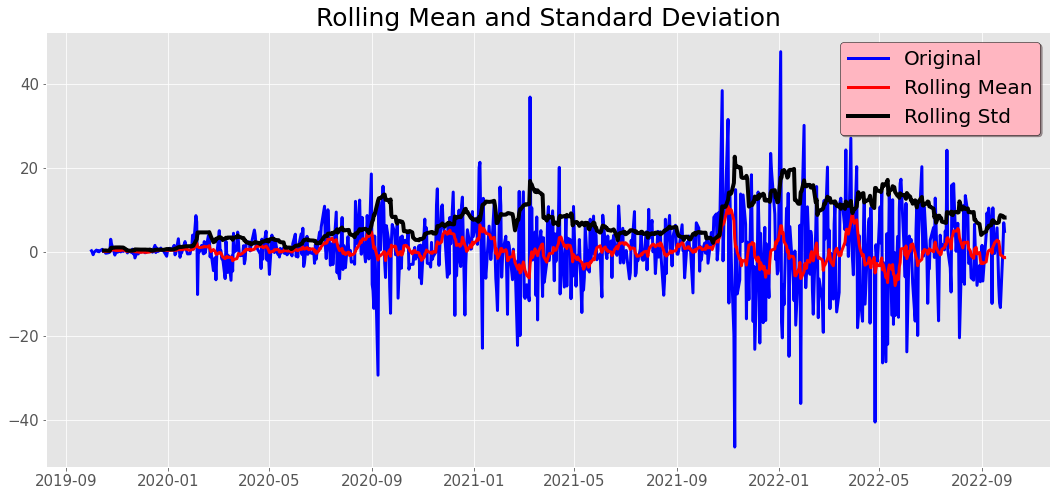

Results of dickey fuller test
Test Statistics               -8.549480e+00
p-value                        9.306971e-14
No. of lags used               9.000000e+00
Number of observations used    7.450000e+02
critical value (1%)           -3.439158e+00
critical value (5%)           -2.865427e+00
critical value (10%)          -2.568840e+00
dtype: float64


In [32]:
# Plot the tsla Adj Close 1st order difference
test_stationarity(tsla_close_diff_1)

we will try to check the treand in the data

breakdown

season cycle error as well

The p-value is obtained is less than significance level of 0.05 and the ADF statistic is lower than any of the critical values.

We can reject the null hypothesis. So, the time series is in fact stationary.

**Decompose the time series :**

To start with, we want to decompose the data to seperate the seasonality, trend and residual. Since we have 3 years of stock data. We would expect there's a yearly or weekly pattern. Let's use a function seasonal_decompose in statsmodels to help us find it.

In [33]:
stock_data[["Close"]]

,Close
Date,
2019-09-30,16.058001
2019-10-01,16.312668
2019-10-02,16.208668
2019-10-03,15.535333
2019-10-04,15.428667
...,...
2022-09-22,288.589996
2022-09-23,275.329987
2022-09-26,276.010010


In [36]:
result=seasonal_decompose(stock_data[["Close"]],period=30)

<Figure size 1440x720 with 0 Axes>

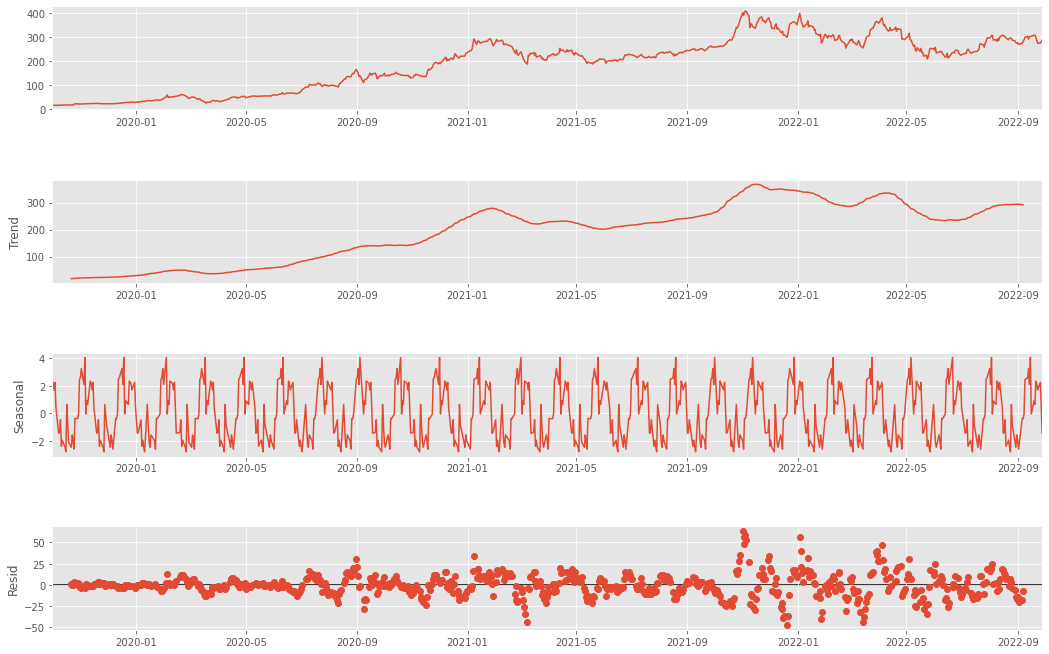

In [37]:
fig=plt.figure(figsize=(20,10))
fig=result.plot()
fig.set_size_inches(17,10)

<Figure size 1440x720 with 0 Axes>

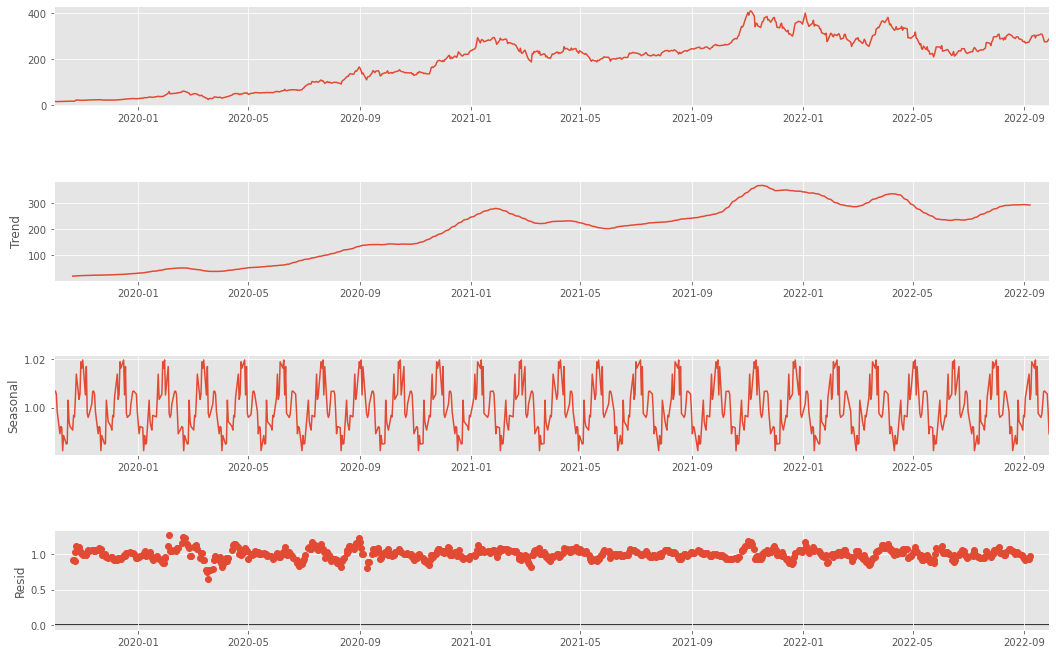

In [39]:
result=seasonal_decompose(stock_data[["Close"]],model="multiplicative",period=30)
fig=plt.figure(figsize=(20,10))
fig=result.plot()
fig.set_size_inches(17,10)

Now we'll create an ARIMA model and train it using the train data's stock closing price. So, let’s visualize the data by dividing it into training and test sets.

In [41]:
a=[1,2,3,4,5,6,7,8,9,10]

In [42]:
a[0:-3]

[1, 2, 3, 4, 5, 6, 7]

In [43]:
a[-3:]

[8, 9, 10]

In [44]:
train_data=df_close[0:-60]

In [45]:
test_data=df_close[-60:]

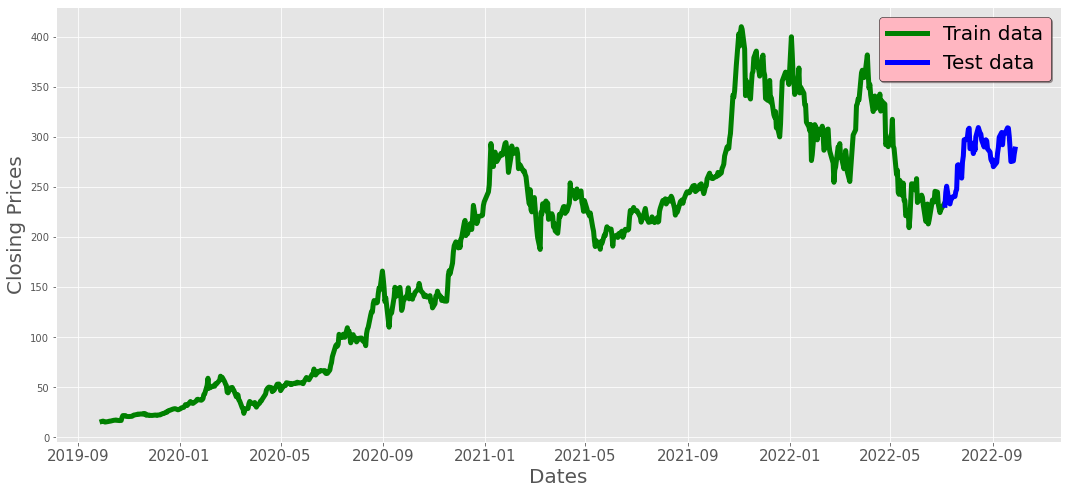

In [46]:
#split data into train and training set
train_data=df_close[0:-60]
test_data=df_close[-60:]
plt.figure(figsize=(18,8))
plt.grid(True)
plt.xlabel('Dates', fontsize = 20)
plt.ylabel('Closing Prices', fontsize = 20)
plt.xticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.plot(train_data, 'green', label='Train data', linewidth = 5)
plt.plot(test_data, 'blue', label='Test data', linewidth = 5)
plt.legend(fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')

In [47]:
var1=tsla_close_diff_1

In [48]:
var=tsla_close_diff_1[1:]

In [49]:
df=pd.DataFrame([var,var1])

In [50]:
df.T.corr

<bound method DataFrame.corr of                 Close      Close
Date                            
2019-10-01        NaN   0.254667
2019-10-02  -0.104000  -0.104000
2019-10-03  -0.673335  -0.673335
2019-10-04  -0.106666  -0.106666
2019-10-07   0.419333   0.419333
...               ...        ...
2022-09-22 -12.209991 -12.209991
2022-09-23 -13.260010 -13.260010
2022-09-26   0.680023   0.680023
2022-09-27   6.929993   6.929993
2022-09-28   4.869995   4.869995

[755 rows x 2 columns]>

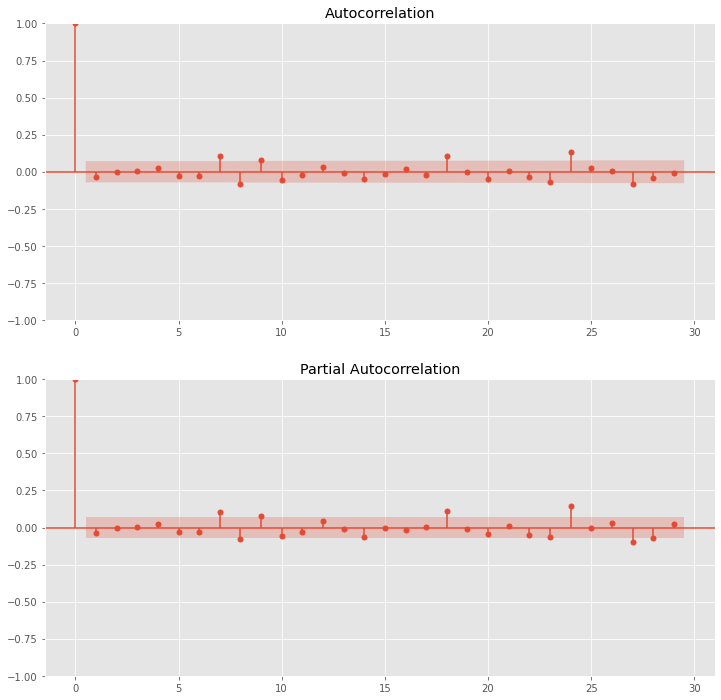

In [51]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)#function
fig = plot_acf(tsla_close_diff_1, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(tsla_close_diff_1, ax=ax2)

In [90]:
# evaluate an ARIMA model for a given order (p,d,q)

def evaluate_arima_model(X, y, arima_order):
    # prepare training dataset
    # make predictions list
    history = [x for x in X]
    predictions = list()
    for t in range(len(y)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(y[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse

In [79]:
# evaluate different combinations of p, d and q values for an ARIMA model to get the best order for ARIMA Model
def evaluate_models(dataset, test, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [56]:
p_values = range(0, 3)

In [57]:
train_data

Date
2019-09-30     16.058001
2019-10-01     16.312668
2019-10-02     16.208668
2019-10-03     15.535333
2019-10-04     15.428667
                 ...    
2022-06-28    232.663330
2022-06-29    228.490005
2022-06-30    224.473328
2022-07-01    227.263336
2022-07-05    233.066666
Name: Close, Length: 696, dtype: float64

In [58]:
test_data

Date
2022-07-06    231.733337
2022-07-07    244.543335
2022-07-08    250.763336
2022-07-11    234.343338
2022-07-12    233.070007
2022-07-13    237.039993
2022-07-14    238.313339
2022-07-15    240.066666
2022-07-18    240.546661
2022-07-19    245.529999
2022-07-20    247.500000
2022-07-21    271.706665
2022-07-22    272.243347
2022-07-25    268.433319
2022-07-26    258.859985
2022-07-27    274.820007
2022-07-28    280.899994
2022-07-29    297.149994
2022-08-01    297.276672
2022-08-02    300.586670
2022-08-03    307.396667
2022-08-04    308.633331
2022-08-05    288.170013
2022-08-08    290.423340
2022-08-09    283.333344
2022-08-10    294.356659
2022-08-11    286.630005
2022-08-12    300.029999
2022-08-15    309.320007
2022-08-16    306.563324
2022-08-17    303.996674
2022-08-18    302.869995
2022-08-19    296.666656
2022-08-22    289.913330
2022-08-23    296.453339
2022-08-24    297.096680
2022-08-25    296.070007
2022-08-26    288.089996
2022-08-29    284.820007
2022-08-30    277.70

In [88]:
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train_data,test_data, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=96.162
ARIMA(0, 0, 1) RMSE=52.971
ARIMA(0, 0, 2) RMSE=30.504
ARIMA(0, 1, 0) RMSE=8.265
ARIMA(0, 1, 1) RMSE=8.295
ARIMA(0, 1, 2) RMSE=8.300
ARIMA(0, 2, 0) RMSE=11.316
ARIMA(0, 2, 1) RMSE=8.242
ARIMA(0, 2, 2) RMSE=8.268
ARIMA(1, 0, 0) RMSE=8.283
ARIMA(1, 0, 1) RMSE=8.312
ARIMA(1, 0, 2) RMSE=8.316
ARIMA(1, 1, 0) RMSE=8.294
ARIMA(1, 1, 1) RMSE=8.298
ARIMA(1, 1, 2) RMSE=8.301
ARIMA(1, 2, 0) RMSE=9.905
ARIMA(1, 2, 1) RMSE=8.268
ARIMA(1, 2, 2) RMSE=8.322
ARIMA(2, 0, 0) RMSE=8.311
ARIMA(2, 0, 1) RMSE=8.310
ARIMA(2, 0, 2) RMSE=8.447
ARIMA(2, 1, 0) RMSE=8.301
ARIMA(2, 1, 1) RMSE=8.311
ARIMA(2, 1, 2) RMSE=8.577
ARIMA(2, 2, 0) RMSE=9.750
ARIMA(2, 2, 1) RMSE=8.273
ARIMA(2, 2, 2) RMSE=8.412
Best ARIMA(0, 2, 1) RMSE=8.242


In [67]:
arima_order=(1,0,1)

In [69]:
history = [x for x in train_data]

In [70]:
history

[16.058000564575195,
 16.312667846679688,
 16.208667755126953,
 15.535332679748535,
 15.428667068481444,
 15.847999572753906,
 16.003332138061523,
 16.302000045776367,
 16.31599998474121,
 16.525999069213867,
 17.130666732788086,
 17.19266700744629,
 17.316667556762695,
 17.46466636657715,
 17.1299991607666,
 16.899999618530273,
 17.038667678833008,
 16.978666305541992,
 19.978666305541992,
 21.875333786010746,
 21.84733390808105,
 21.08133316040039,
 21.000667572021484,
 20.994667053222656,
 20.88733291625977,
 21.1646671295166,
 21.14800071716309,
 21.77199935913086,
 22.369333267211918,
 22.47599983215332,
 23.006000518798828,
 23.32866668701172,
 23.073999404907227,
 23.290000915527344,
 23.47800064086914,
 23.332666397094727,
 23.968000411987305,
 23.481332778930664,
 23.655332565307617,
 22.202667236328125,
 22.422666549682617,
 21.92799949645996,
 22.086000442504883,
 21.996000289916992,
 22.32466697692871,
 22.413333892822266,
 22.20199966430664,
 22.024667739868164,
 22.392667

In [73]:
model = ARIMA(history, order=arima_order)

In [74]:
model_fit = model.fit()

In [75]:
yhat = model_fit.summary()
       

In [76]:
yhat

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  696
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2490.902
Date:                Thu, 29 Sep 2022   AIC                           4989.804
Time:                        12:11:24   BIC                           5007.985
Sample:                             0   HQIC                          4996.834
                                - 696                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        183.9141     65.797      2.795      0.005      54.954     312.874
ar.L1          0.9974      0.002    443.533      0.000       0.993       1.002
ma.L1         -0.0405      0.031     -1.319      0.187      -0.101       0.020
sigma2        74.6293      2.153     34.661      0.000      70.409      78.849
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               738.84
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              15.31   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SARIMA Model

In [125]:
train_data=tsla_close_diff_1[0:-60]
test_data=tsla_close_diff_1[-60:]

In [126]:
history = [x for x in train_data]
predictions = list()
conf_list = list()
for t in range(len(test_data)):
    model = sm.tsa.statespace.SARIMAX(history, order = (0,1,0), seasonal_order = (1,1,1,3))
    model_fit = model.fit()
    fc = model_fit.forecast()
    predictions.append(fc)
    history.append(test_data[t])
print('RMSE of SARIMA Model:', np.sqrt(mean_squared_error(test_data, predictions)))

RMSE of SARIMA Model: 11.313435980566087


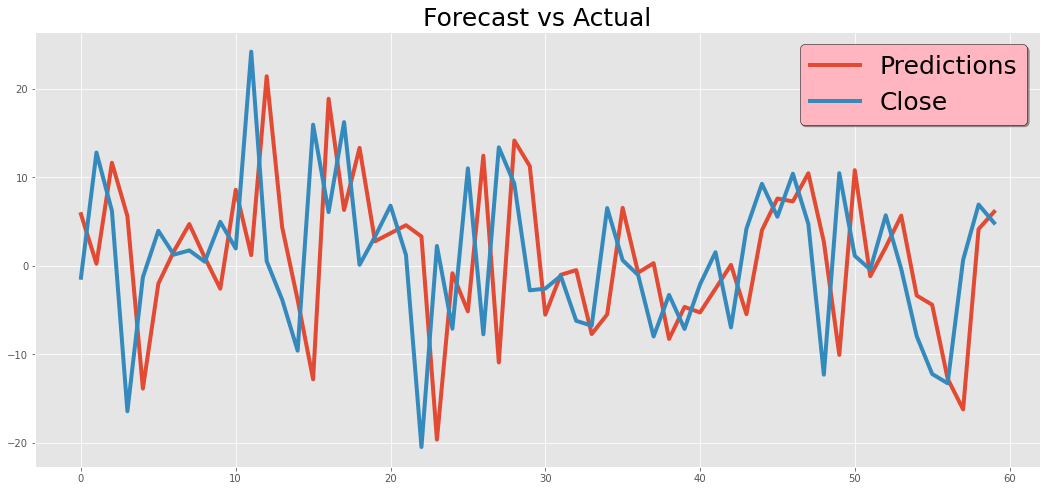

In [127]:
plt.figure(figsize=(18,8))
plt.title('Forecast vs Actual', fontsize = 25)
plt.plot(range(60), predictions, label = 'Predictions', linewidth = 4)
plt.plot(range(60), test_data, label = 'Close', linewidth = 4)
plt.legend(fontsize = 25, shadow=True,facecolor='lightpink',edgecolor = 'k')